### **Movie Embeddings**

Instead of embedding words, we will embed movies.  In particular, if we can embed movies, then similar movies will be close to each other and can be recommended.  This line of reasoning  is analogous to the [distributional hypothesis of word meanings]. For words, this roughly translates to words that appear in similar sentences should have similar vector representations. For movies, vectors for two movies should be similar if they are watched by similar people. 

Let the total number of movies be $M$. Let $X_{i,j}$ be the number of users that liked both movies $i$ and $j$. We want to obtain vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.


 -  **Compute data $X_{i,j}$ from the movielens (small) [dataset] and [description]. Briefly describe your data prep workflow (you can use `pandas` if needed).**

 -  **Optimize function $c(v_1,...,v_M)$ over $v_1,...,v_M$ using gradient descent (using `pytorch` or `tensorflow`). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).**
 -  **Recommend top 10 movies (not vectors or indices but movie names) given movies (a) _Apollo 13_, (b) _Toy Story_, and (c) _Home Alone_ . Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?**

**PART A:** Compute data $X_{i,j}$ from the movielens (small) dataset and description. Briefly describe your data prep workflow (you can use pandas if needed).

In [53]:
#Importing the libraries
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [54]:
#Reading movies and ratings data into dataframes from csv 
movies_dataframe = pd.read_csv("movies.csv")
ratings_dataframe = pd.read_csv("ratings.csv")
#putting the year in a new column after being removed from the title column
movies_dataframe['Genre'] = movies_dataframe.genres.str.split('|')
movies_dataframe['Year'] = movies_dataframe.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies_dataframe['Movie_Title'] = movies_dataframe.title.str.replace('(\(\d\d\d\d\))', '')
movies_dataframe['Year'] = movies_dataframe.Year.str.extract('(\d\d\d\d)',expand=False)
movies_dataframe['Movie_Title'] = movies_dataframe['title'].apply(lambda x: x.strip())
length_of_df= len(movies_dataframe)
#taking care of the values in the Genre column by splitting
Genre_movie = movies_dataframe
#printing the dataframe
movies_dataframe.head()

C:\Users\TV\AppData\Local\Temp/ipykernel_10000/1767327448.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_dataframe['Movie_Title'] = movies_dataframe.title.str.replace('(\(\d\d\d\d\))', '')


,movieId,title,genres,Genre,Year,Movie_Title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Toy Story (1995)
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995,Jumanji (1995)
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",1995,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",1995,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],1995,Father of the Bride Part II (1995)


In [55]:
#We individually consider the genres in order to use them as a foundation for matching the movies to particular audiences.
for i, j in movies_dataframe.iterrows():
    for g in j['Genre']:
        Genre_movie.at[i, g] = 1

#Replacing na with 0
Genre_movie = Genre_movie.fillna(0)
# Time stamps are removed since we don't require them
Ratings = ratings_dataframe.drop('timestamp', 1)
print(Ratings)

        userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100836 rows x 3 columns]


C:\Users\TV\AppData\Local\Temp/ipykernel_10000/2458763020.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Ratings = ratings_dataframe.drop('timestamp', 1)


In [56]:
#Finding and printing the number of Users
users = Ratings["userId"]
user_uniq = users.unique()
userid = user_uniq.tolist()
user_user_en = {i: x for i, x in enumerate(userid)}
user_user = {x: i for i, x in enumerate(userid)}
Ratings["user"] = Ratings["userId"].map(user_user)
no_of_users = len(user_user)
print("Number of Users: {}".format(no_of_users))

Number of Users: 610


In [57]:
#Finding and printing the number of Movies
movies = Ratings["movieId"]
movies_uniq= movies.unique()
moviesid= movies_uniq.tolist()  
movie_movie_en = {i: x for i, x in enumerate(moviesid)}
movie_movie = {x: i for i, x in enumerate(moviesid)}
Ratings["movie"] = Ratings["movieId"].map(movie_movie)
no_of_movies = len(movie_movie_en)
print("Number of Movies: {}".format(no_of_movies))
Ratings["rating"] = Ratings["rating"].values

Number of Movies: 9724


In [58]:
#Normalizing the ratings
minimum_rate = min(Ratings["rating"])
maximum_rate = max(Ratings["rating"])
#Random Sampling the data
Ratings = Ratings.sample(frac=1, random_state=10)
X_ind = Ratings[["user", "movie"]].values
#Printing the minimum and maximum ratings among all
print("Minimum Rating: {}".format(minimum_rate))
print("Maximum Rating: {}".format(maximum_rate))

Minimum Rating: 0.5
Maximum Rating: 5.0


In [59]:
#Normalizing the target variable
Y_lab = Ratings["rating"].apply(lambda x: (x - minimum_rate) / (maximum_rate - minimum_rate)).values
#Splitting the data into Training Data: 80% and Validation Data: 20%
train = int(0.8 * Ratings.shape[0])
#Spitting the training and validation data
x_train, x_valid, y_train, y_valid = (X_ind[:train], X_ind[train:], Y_lab[:train], Y_lab[train:],)

In [61]:
#Creating a recommend class for our recommender system
Emb = 50 # Taking the embedding size as 50
class recommend(keras.Model):
  def __init__(self, no_of_users, no_of_movies, emb, **kwargs):
    super(recommend, self).__init__(**kwargs)
    self.user_emb = layers.Embedding(
            no_of_users,
            emb,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
    self.movie_emb = layers.Embedding(
            no_of_movies,
            emb,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
    self.user_bias = layers.Embedding(no_of_users, 1)
    self.movie_bias = layers.Embedding(no_of_movies, 1)
    self.no_of_users = no_of_users
    self.no_of_movies = no_of_movies
    self.emb = emb
  # Creating a function to combine all the components
  def call(self, inputs):
    u_vector = self.user_emb(inputs[:, 0])
    m_vector = self.movie_emb(inputs[:, 1])
    u_bias = self.user_bias(inputs[:, 0])
    m_bias = self.movie_bias(inputs[:, 1])
    user_mov_td= tf.tensordot(u_vector, m_vector, 2)
    res = u_bias + m_bias + user_mov_td
    return res

In [62]:
#Creating the Adam model with learning rate= 0.0001 and compiling it
model_adam = recommend(no_of_users, no_of_movies, Emb) 
model_adam.compile(loss = tf.keras.losses.MeanAbsoluteError(), optimizer = keras.optimizers.Adam(learning_rate = 0.0001))   

In [63]:
#Fitting the Adam model with batch size=32 and epoch=7
hist_adam = model_adam.fit(x=x_train, y=y_train, batch_size=32, epochs=7, verbose=2,validation_data=(x_valid, y_valid),)


Epoch 1/7
2521/2521 - 15s - loss: 0.6081 - val_loss: 0.5297 - 15s/epoch - 6ms/step
Epoch 2/7
2521/2521 - 13s - loss: 0.3009 - val_loss: 0.2190 - 13s/epoch - 5ms/step
Epoch 3/7
2521/2521 - 13s - loss: 0.1824 - val_loss: 0.2325 - 13s/epoch - 5ms/step
Epoch 4/7
2521/2521 - 13s - loss: 0.1690 - val_loss: 0.2253 - 13s/epoch - 5ms/step
Epoch 5/7
2521/2521 - 13s - loss: 0.1623 - val_loss: 0.2230 - 13s/epoch - 5ms/step
Epoch 6/7
2521/2521 - 13s - loss: 0.1580 - val_loss: 0.2139 - 13s/epoch - 5ms/step
Epoch 7/7
2521/2521 - 13s - loss: 0.1548 - val_loss: 0.2139 - 13s/epoch - 5ms/step


In [64]:
#Creating the SGD model with learning rate= 0.001 and compiling it
model_sgd= recommend(no_of_users, no_of_movies, Emb) 
model_sgd.compile( loss = tf.keras.losses.MeanAbsoluteError(), optimizer = keras.optimizers.SGD(learning_rate = 0.001)) 

In [65]:
#Fitting the SGD model with batch size=32 and epoch=7
hist_sgd = model_sgd.fit( x=x_train, y=y_train, batch_size=32, epochs=7, verbose=2, validation_data=(x_valid, y_valid),)

Epoch 1/7
2521/2521 - 13s - loss: 0.6634 - val_loss: 0.6533 - 13s/epoch - 5ms/step
Epoch 2/7
2521/2521 - 12s - loss: 0.6420 - val_loss: 0.6376 - 12s/epoch - 5ms/step
Epoch 3/7
2521/2521 - 12s - loss: 0.6209 - val_loss: 0.6221 - 12s/epoch - 5ms/step
Epoch 4/7
2521/2521 - 12s - loss: 0.6003 - val_loss: 0.6070 - 12s/epoch - 5ms/step
Epoch 5/7
2521/2521 - 12s - loss: 0.5802 - val_loss: 0.5923 - 12s/epoch - 5ms/step
Epoch 6/7
2521/2521 - 12s - loss: 0.5608 - val_loss: 0.5782 - 12s/epoch - 5ms/step
Epoch 7/7
2521/2521 - 12s - loss: 0.5422 - val_loss: 0.5647 - 12s/epoch - 5ms/step


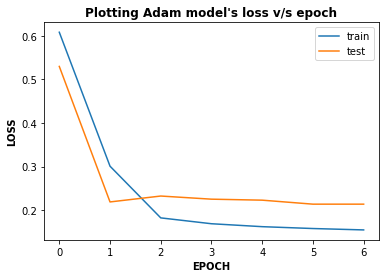

In [66]:
#Plotting the loss v/s epoch for Adam model
plt.title("Plotting Adam model's loss v/s epoch", fontweight='bold')
plt.plot(hist_adam.history["loss"])
plt.plot(hist_adam.history["val_loss"])
plt.legend(["train", "test"], loc="upper right")
plt.ylabel("LOSS", fontweight='bold')
plt.xlabel("EPOCH", fontweight='bold')
plt.show()

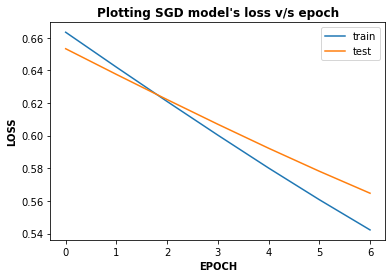

In [67]:
#Plotting the loss v/s epoch for SGD model
plt.title("Plotting SGD model's loss v/s epoch", fontweight='bold')
plt.plot(hist_sgd.history["loss"])
plt.plot(hist_sgd.history["val_loss"])
plt.legend(["train", "test"], loc="upper right")
plt.ylabel("LOSS", fontweight='bold')
plt.xlabel("EPOCH", fontweight='bold')
plt.show()

The loss's value rises together with our learning rate, as was previously demonstrated. The lowest loss for the training dataset while employing the Adam optimizer with a learning rate of 0.0001 was 0.1553. This loss saw a sharp fall, which was then followed by a slow decline. The minimal loss for the training dataset for SGD with a learning rate of 0.001 was 0.5403, and then the loss gradually decreased over time. So, we can reach to this conclusion that, with a lower learning rate value, performance increases.

In [68]:
#Creating a pivot table and filling na with 0s
Df_final = Ratings.pivot(index='movieId',columns='userId',values='rating').fillna(0)
#Getting number of users that voted by taking the aggregated count
num_of_user_voted = Ratings.groupby('movieId')['rating'].agg('count')
#Getting number of movies that got voted by taking the aggregated count
num_of_movies_voted = Ratings.groupby('userId')['rating'].agg('count')
print("Number of user voted:")
print (num_of_user_voted)
print("\nNumber of movies got voted:")
print (num_of_movies_voted)

Number of user voted:
movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

Number of movies got voted:
userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


c:\users\tv\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


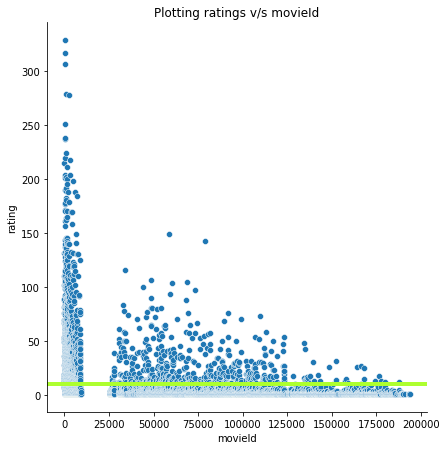

In [69]:
#Plotting ratings v/s movieid
sns.FacetGrid(Df_final, size = 6)
v = sns.scatterplot(x = num_of_user_voted.index,y = num_of_user_voted, palette='pastel')
v.axhline(y= 10, linewidth=4, color='greenyellow')
plt.title("Plotting ratings v/s movieId")
plt.show()

In [70]:
#From the above plot we are setting movie rating above threshold to 10
Df_final = Df_final.loc[num_of_user_voted[num_of_user_voted > 10].index, :]
Df_final

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\users\tv\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


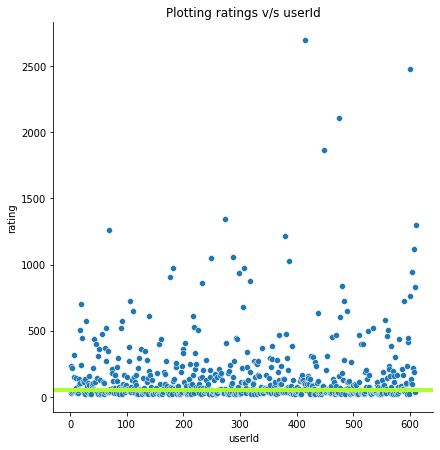

In [71]:
#Plotting ratings v/s userid
sns.FacetGrid(Df_final, size = 6)
v = sns.scatterplot(x = num_of_movies_voted.index,y = num_of_movies_voted, palette='pastel')
v.axhline(y= 50, linewidth=4, color ="greenyellow")
plt.title("Plotting ratings v/s userId")
plt.show()

In [72]:
#From the above plot we are setting user rating above threshold to 50
Df_final = Df_final.loc[:, num_of_movies_voted[num_of_movies_voted > 50].index]
Df_final

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
#Creating a csr matrix and removing sparsity
final_df = csr_matrix(Df_final.values) 
Df_final.reset_index(inplace = True)
final_df

<2121x378 sparse matrix of type '<class 'numpy.float64'>'
	with 72893 stored elements in Compressed Sparse Row format>

In order to find the closest neighbors, we will be applying the cosine similarity technique, therefore we chose to use kNN for the movie recommendations for the afore mentioned movie names.



In [74]:
#Creating a knn model with 10 neighbors
neigh = NearestNeighbors(metric = 'cosine', n_neighbors = 10)
neigh.fit(final_df)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [75]:
#Creating a function for recommending the movie
def Recommended_movie_for(name_of_movie):
  
    list_of_movie = movies_dataframe[movies_dataframe['title'].str.contains(name_of_movie)]
    if len(list_of_movie):
        id = list_of_movie.iloc[0]['movieId']
        id = Df_final[Df_final['movieId'] == id].index[0]
        d, i = neigh.kneighbors(final_df[id], n_neighbors = 10 +1)
        movie_i = sorted(list(zip(i.squeeze().tolist(), d.squeeze().tolist())), key = lambda x :x[1])[:0:-1]
        
         
        frame = []
        for k in movie_i:
            id = Df_final.iloc[k[0]]['movieId']
            id = movies_dataframe[movies_dataframe['movieId'] == id].index
            frame.append({'Title': movies_dataframe.iloc[id]['title'].values[0], 'distance': k[1]})
            
        final_dataset = pd.DataFrame(frame, index=range(1, 10 +1))
        return final_dataset

In [76]:
print('Recommended movie for Apollo 13')
Recommended_movie_for('Apollo 13')

Recommended movie for Apollo 13


,Title,distance
1,Speed (1994),0.406600
2,Aladdin (1992),0.398175
3,Braveheart (1995),0.396385
4,True Lies (1994),0.392396
5,Terminator 2: Judgment Day (1991),0.388963
6,Toy Story (1995),0.384633
7,"Fugitive, The (1993)",0.381795
8,"Shawshank Redemption, The (1994)",0.380409
9,Forrest Gump (1994),0.348578
10,Jurassic Park (1993),0.343623


In [77]:
print('Recommended movie for Toy Story')
Recommended_movie_for('Toy Story')

Recommended movie for Toy Story


,Title,distance
1,Groundhog Day (1993),0.399495
2,"Lion King, The (1994)",0.398578
3,Pulp Fiction (1994),0.398293
4,Star Wars: Episode VI - Return of the Jedi (1983),0.390663
5,Apollo 13 (1995),0.384633
6,Shrek (2001),0.381472
7,Star Wars: Episode IV - A New Hope (1977),0.380789
8,Toy Story 2 (1999),0.371637
9,Forrest Gump (1994),0.356542
10,Jurassic Park (1993),0.334884


In [78]:
print('Recommended movie for Home Alone')
Recommended_movie_for('Home Alone')

Recommended movie for Home Alone


,Title,distance
1,True Lies (1994),0.487959
2,Indiana Jones and the Temple of Doom (1984),0.467394
3,"Mask, The (1994)",0.466844
4,Pretty Woman (1990),0.454946
5,Forrest Gump (1994),0.454670
6,Jurassic Park (1993),0.454285
7,Aladdin (1992),0.451129
8,Jumanji (1995),0.443432
9,Mrs. Doubtfire (1993),0.405160
10,"Lion King, The (1994)",0.403325
